In [ ]:
figure = [84.0, 88.46, 88.46]
bottle = [62.96, 92.59, 96.29]
pen = [55.56,72.22 , 94.4]
guitar = [56.25, 68.75, 75.0]

In [1]:
import sys
sys.path.append(r"C:\Users\49174\anaconda3\envs\praktikum\Lib\site-packages")
import torch
import numpy as np
from dataset_jacquard_samples import JacquardSamples
from utils import get_transform, get_inv_transform
from bce_model import BCEGraspTransformer
from utils_train import create_correct_false_points
import random
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
from metrics_utils import * 
from infer_utils import * 
from PIL import Image, ImageDraw

xFormers not available
xFormers not available


In [2]:
IMAGE_SIZE = 1120 
PATCH_DIM = IMAGE_SIZE //14
IDX = 3 #id of the object in the category

In [3]:
split_train = r"Figure_train/"
split_test = r"Figure_test/"

## Init the Valid Input Point Model 

In [4]:
args_infer = {
    "model_path" : "runs/figure_4_single.ckpt",
    "device" : "cuda",
    "img_size" : IMAGE_SIZE
}

In [5]:
device = torch.device(args_infer["device"]) if torch.cuda.is_available() else torch.device("cpu")
image_transform = get_transform()
inv_transform = get_inv_transform()
model = BCEGraspTransformer(img_size=IMAGE_SIZE,int_dim=256,output_dim=128)
dataset_train = JacquardSamples(dataset_root= split_train ,image_transform=image_transform, num_targets=5, overfit=False,
                              img_size=args_infer["img_size"], idx=4)
dataset = JacquardSamples(dataset_root= split_test ,image_transform=image_transform, num_targets=5, overfit=False,
                              img_size=args_infer["img_size"], idx=7)
model.load_state_dict(torch.load(args_infer["model_path"]))
model = model.to(device)

## Init the Second Point Model 

In [6]:
args_infer_single = {
    "model_path" : "runs/figure_4_double.ckpt",
    "device" : "cuda",
    "img_size" : 1120
}


In [7]:
device = torch.device(args_infer["device"])
image_transform = get_transform()
inv_transform = get_inv_transform()
model_single = BCEGraspTransformer(img_size=args_infer_single["img_size"],int_dim=256,output_dim=32)
model_single.load_state_dict(torch.load(args_infer_single["model_path"]))
model_single = model_single.to(device)

In [8]:
constrain_mode = True
TOPK = True
topk_grasps = 1
topk_input = 70

In [9]:
max_dist =0
min_dist = 999999
for i in range(len(dataset_train)):
    data = dataset_train[i]
    img = data["img"].to(device)
    img = torch.permute(img, (0, 2, 1))
    mask = data["mask"].sum().sqrt()
    all_points = torch.tensor(data["points_grasp"]//14)
    dif = (all_points[:, 0, :] - all_points[:, 1, :]).type(torch.float32).norm(p=2, dim=1)
    dif_n = (dif/mask).unsqueeze(1)
    if max_dist < dif_n.max():
        max_dist = dif_n.max()
    if min_dist > dif_n.min() and dif_n.min()>0:
        min_dist = dif_n.min()
if min_dist < 0.01:
    min_dist = 0.01

C:\Users\49174\Desktop\prak_proj\ZeroShot-Grasping\MLP-approach\dataset_jacquard_samples.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict['points_grasp'] = torch.tensor(points_grasps)
C:\Users\49174\Desktop\prak_proj\ZeroShot-Grasping\MLP-approach\dataset_jacquard_samples.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_dict['raw'] = torch.tensor(gknet_labels)
C:\Users\49174\AppData\Local\Temp\ipykernel_1832\3396165159.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_points = torch.tensor(data["points_grasp"]

In [10]:
print(len(dataset))

26


In [17]:
accuracies = []
for test_idx in range(len(dataset)): 
    data = dataset[test_idx]
    img = data["img"].to(device)
    mask = data["mask"].to(device)
    img = torch.permute(img, (0, 2, 1))
    grasp = data["points_grasp"]//14
    normal_grasp = grasp.clone()
    grasp_inv = torch.cat([grasp[:,1,:].unsqueeze(1), grasp[:,0,:].unsqueeze(1)], dim=1)
    grasp = torch.cat([grasp, grasp_inv], dim=0)
    #get features from dino
    features,_ = model.forward_dino_features(img.unsqueeze(0))
    features = features.squeeze().reshape(PATCH_DIM, PATCH_DIM, 768)

    #plt.figure(figsize=(16,16))
    org_image = torch.permute(inv_transform(img), (1, 2, 0)).cpu().numpy()
    #plt.imshow(org_image)


    ## get valid points
    all_points = torch.tensor([[i,j] for j in range(PATCH_DIM) for i in range(PATCH_DIM)]).unsqueeze(1).to(device)


    preds, preds_patches = get_valid_points(all_points, features, model, device,PATCH_DIM=PATCH_DIM)

    preds_cp, pts, valid_pts_pred = get_topk_valid_points(preds,preds_patches, mask, topk_num=topk_input,TOP_K=TOPK)

    #get second point informations 
    mask, mask_n, _, _, grasp, heights, corners = get_second_point_data(dataset,4,model_single,device,args_infer, inv_transform,test_idx=test_idx)

    num_grasps = valid_pts_pred.shape[0]
    #objs = 1


    data = {}
    data['mask'] = mask
    data['valid_pts_pred'] = valid_pts_pred
    data['min_dist'] = min_dist
    data['max_dist'] = max_dist
    data['heights'] = heights
    data['args_infer'] = args_infer
    data['mask_n'] = mask_n
    data['device'] = device
    data['features'] = features
    data['model_single'] = model_single

    ##currently only support constraint mode == false
    items = get_predictions(num_grasps,data,constrain_mode=constrain_mode)
    try:
        cur_accuracy, best_gt_grasp = vis_preds_with_metrics(num_grasps, items, org_image, grasp,heights, args_infer,preds_cp,topks=topk_grasps)
        accuracies.append(cur_accuracy)
    except:
        continue
    

    print('Object accuracy is', sum(accuracies)/len(accuracies))

KeyboardInterrupt: 

### Loop over the data and get the metrics

# GET VISUALIZATION
# -----------------------------------------------------------------------
# -----------------------------------------------------------------------
# -----------------------------------------------------------------------
# -----------------------------------------------------------------------
# -----------------------------------------------------------------------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Accuracy is 100.0 %
Object accuracy is 100.0


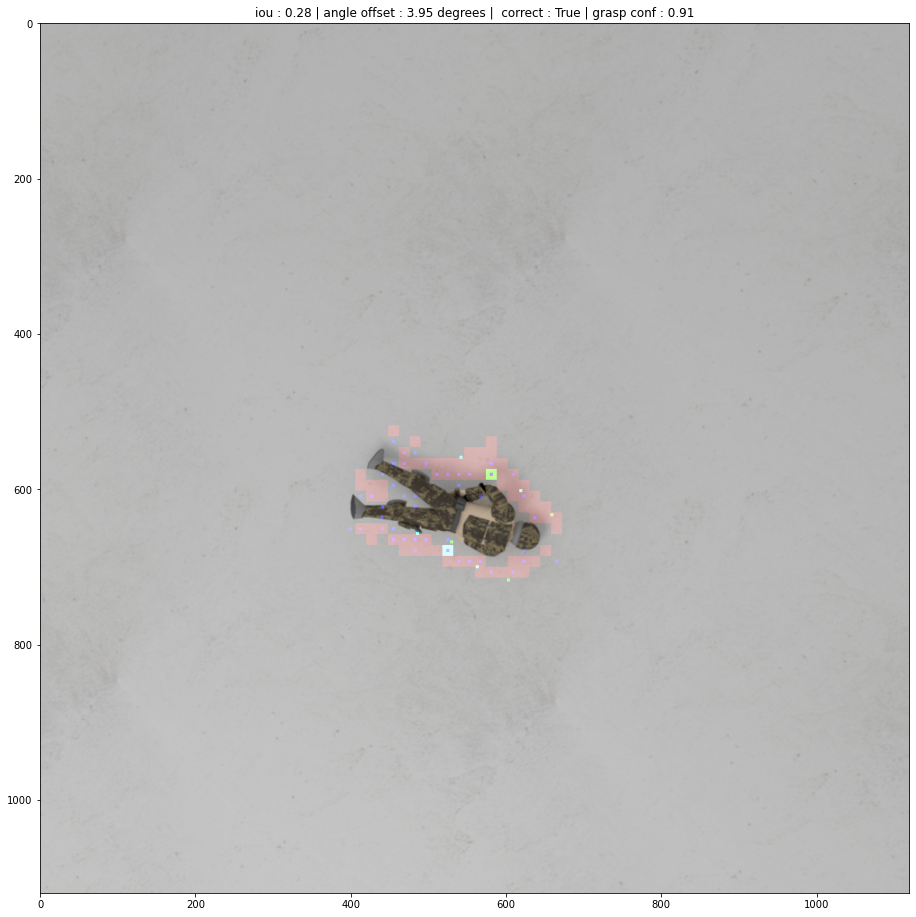

In [18]:
accuracies = []
for test_idx in range(1): 
    test_idx = 7
    data = dataset[test_idx]
    img = data["img"].to(device)
    mask = data["mask"].to(device)
    img = torch.permute(img, (0, 2, 1))
    grasp = data["points_grasp"]//14
    normal_grasp = grasp.clone()
    grasp_inv = torch.cat([grasp[:,1,:].unsqueeze(1), grasp[:,0,:].unsqueeze(1)], dim=1)
    grasp = torch.cat([grasp, grasp_inv], dim=0)
    #get features from dino
    features,_ = model.forward_dino_features(img.unsqueeze(0))
    features = features.squeeze().reshape(PATCH_DIM, PATCH_DIM, 768)

    #plt.figure(figsize=(16,16))
    org_image = torch.permute(inv_transform(img), (1, 2, 0)).cpu().numpy()
    #plt.imshow(org_image)


    ## get valid points
    all_points = torch.tensor([[i,j] for j in range(PATCH_DIM) for i in range(PATCH_DIM)]).unsqueeze(1).to(device)


    preds, preds_patches = get_valid_points(all_points, features, model, device,PATCH_DIM=PATCH_DIM)

    preds_cp, pts, valid_pts_pred = get_topk_valid_points(preds,preds_patches, mask, topk_num=topk_input,TOP_K=TOPK)

    #get second point informations 
    mask, mask_n, _, _, grasp, heights, corners = get_second_point_data(dataset,4,model_single,device,args_infer, inv_transform,test_idx=test_idx)

    num_grasps = valid_pts_pred.shape[0]
    #objs = 1


    data = {}
    data['mask'] = mask
    data['valid_pts_pred'] = valid_pts_pred
    data['min_dist'] = min_dist
    data['max_dist'] = max_dist
    data['heights'] = heights 
    data['args_infer'] = args_infer
    data['mask_n'] = mask_n
    data['device'] = device
    data['features'] = features
    data['model_single'] = model_single

    ##currently only support constraint mode == false
    items = get_predictions(num_grasps,data,constrain_mode=constrain_mode)
    try:
        cur_accuracy, best_gt_grasp = vis_preds_with_metrics(num_grasps, items, org_image, grasp,heights, args_infer,preds_cp,topks=topk_grasps)
        accuracies.append(cur_accuracy)
    except:
        accuracies.append(0.)
    

    print('Object accuracy is', sum(accuracies)/len(accuracies))

In [19]:
print(best_gt_grasp)

tensor([[609, 623],
        [693, 567]], dtype=torch.int32)


In [20]:
preds_patches = torch.nn.functional.interpolate(preds_patches, (args_infer["img_size"], args_infer["img_size"]), mode="bilinear").squeeze()
items = sorted(items, key=lambda x: x['conf'], reverse=True)
first_point = items[0]["single_point"]
pred_point = items[0]["pred_point"]
zeros = torch.zeros(args_infer["img_size"], args_infer["img_size"], 2)
preds_patches = torch.cat([preds_patches.cpu().unsqueeze(2), zeros], dim=2)
preds_patches = torch.permute(preds_patches, (1, 0, 2))

In [21]:
img = Image.new("RGB", (1120, 1120))


x = first_point[1].numpy()
y = first_point[0].numpy()
r = 5
leftUpPoint = (x-r, y-r)
rightDownPoint = (x+r, y+r)
twoPointList = [leftUpPoint, rightDownPoint]

x2 = pred_point[1].numpy()
y2 = pred_point[0].numpy()
r2 = 5
leftUpPoint2 = (x2-r2, y2-r2)
rightDownPoint2 = (x2+r2, y2+r2)
twoPointList2 = [leftUpPoint2, rightDownPoint2]


img1 = ImageDraw.Draw(img)  
img1.ellipse(twoPointList, fill=(0,255,0,255))
img1.ellipse(twoPointList2, fill=(0,255,255,255))
img = np.asarray(img)


save_dir =r"pres_visuals/"

plt.figure(figsize=(16,16))
last_im = org_image + preds_patches.numpy()*0.2 + img
last_im[last_im > 1.] = 1.
#plt.imshow(last_im)
plt.imsave(save_dir+"figure_2.png",last_im )

<Figure size 1152x1152 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


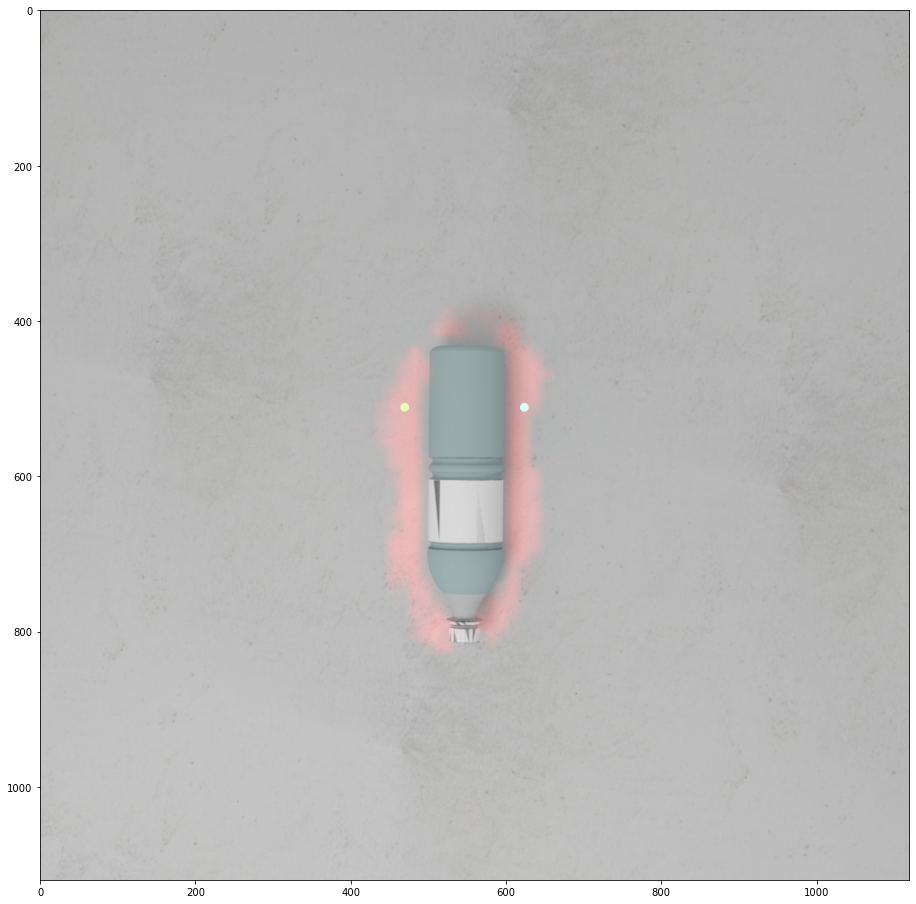